In [56]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter

from datetime import datetime
import pytz

from pymongo import MongoClient
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [58]:
from Functions import Read_data as RD
day_start = datetime.now() - relativedelta(days=60)
day_end = datetime.now() - relativedelta(days=40)
tickers = ['BTC','ETH', 'SOL','BNB','ADA','XLM','DOGE','TRX','LINK','AVAX']
dfs = RD.load_multiple_tickers(tickers, start_date=day_start, end_date=day_end, max_gap_seconds=60)

Loading data for BTC...
Processed 10000 records...
Split data into 2 continuous segments
Total records processed: 14835
Loaded 2 segments for BTC
Loading data for ETH...
Processed 10000 records...
Split data into 2 continuous segments
Total records processed: 14835
Loaded 2 segments for ETH
Loading data for SOL...
Processed 10000 records...
Split data into 2 continuous segments
Total records processed: 14833
Loaded 2 segments for SOL
Loading data for BNB...
Processed 10000 records...
Split data into 2 continuous segments
Total records processed: 14834
Loaded 2 segments for BNB
Loading data for ADA...
Processed 10000 records...
Split data into 2 continuous segments
Total records processed: 14835
Loaded 2 segments for ADA
Loading data for XLM...
Processed 10000 records...
Split data into 2 continuous segments
Total records processed: 14835
Loaded 2 segments for XLM
Loading data for DOGE...
Processed 10000 records...
Split data into 2 continuous segments
Total records processed: 14832
Loa

In [59]:
for df in dfs:
    print(len(df))

358
180


In [60]:
dfs[0].corr()

,BTC,ETH,SOL,BNB,ADA,XLM,DOGE,TRX,LINK,AVAX
BTC,1.000000,0.741340,0.828396,0.862330,0.349631,0.798479,0.300319,-0.853388,0.853492,0.877871
ETH,0.741340,1.000000,0.714218,0.638443,0.428863,0.712488,0.459693,-0.533898,0.717726,0.823125
SOL,0.828396,0.714218,1.000000,0.833311,0.391762,0.802664,0.611138,-0.663464,0.718162,0.745117
BNB,0.862330,0.638443,0.833311,1.000000,0.149734,0.733410,0.421387,-0.895044,0.735868,0.769307
ADA,0.349631,0.428863,0.391762,0.149734,1.000000,0.710695,0.565004,-0.066664,0.621243,0.565540
XLM,0.798479,0.712488,0.802664,0.733410,0.710695,1.000000,0.580376,-0.629826,0.919671,0.867386
DOGE,0.300319,0.459693,0.611138,0.421387,0.565004,0.580376,1.000000,-0.076857,0.399537,0.437371
TRX,-0.853388,-0.533898,-0.663464,-0.895044,-0.066664,-0.629826,-0.076857,1.000000,-0.711227,-0.774298
LINK,0.853492,0.717726,0.718162,0.735868,0.621243,0.919671,0.399537,-0.711227,1.000000,0.907648
AVAX,0.877871,0.823125,0.745117,0.769307,0.565540,0.867386,0.437371,-0.774298,0.907648,1.000000


In [61]:
def test_cointegration(df, symbol1, symbol2, missing_threshold=0.3, plot=False):
    try:
        pair_data = df[[symbol1, symbol2]].copy()
        total_rows = len(pair_data)
        
        missing_count = pair_data.isnull().sum()
        valid_data = pair_data.dropna()
        
        rows_dropped = total_rows - len(valid_data)
        missing_ratio = rows_dropped / total_rows
        
        if missing_ratio > missing_threshold:
            return {
                'Error': f"Too many missing values ({missing_ratio:.2%})",
                'Is Cointegrated': False
            }
            
        if (valid_data[symbol1] <= 0).any() or (valid_data[symbol2] <= 0).any():
            return {
                'Error': f"Zero or negative values in {symbol1} or {symbol2}",
                'Is Cointegrated': False
            }
            
        y = np.log(valid_data[symbol1])
        x = np.log(valid_data[symbol2])
        
        x_with_const = sm.add_constant(x)
        model = sm.OLS(y, x_with_const).fit()
        
        alpha = model.params.iloc[0]
        beta = model.params.iloc[1]
        
        spread = y - (alpha + beta * x)
        
        adf_result = adfuller(spread)
        
        result = {
            'ADF Statistic': adf_result[0],
            'p-value': adf_result[1],
            'Critical Values': adf_result[4],
            'Is Cointegrated': adf_result[1] < 0.05,
            'Missing Ratio': missing_ratio,
            'Valid Data': valid_data
        }
        
        if plot:
            plt.figure(figsize=(12, 6))
            
            norm_y = y / y.iloc[0]
            norm_x = x / x.iloc[0]
            plt.plot(norm_y, label=symbol1)
            plt.plot(norm_x, label=symbol2)
            plt.legend()
            plt.title(f'Normalized Log Prices: {symbol1} vs {symbol2}')
            plt.grid(True, alpha=0.3)
            plt.show()
            
            plt.figure(figsize=(12, 6))
            plt.plot(spread)
            plt.title(f'Spread between {symbol1} and {symbol2}')
            plt.axhline(y=np.mean(spread), color='r', linestyle='--', label='Mean')
            plt.axhline(y=np.mean(spread) + 2*np.std(spread), color='g', linestyle='--', label='+2σ')
            plt.axhline(y=np.mean(spread) - 2*np.std(spread), color='g', linestyle='--', label='-2σ')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        
        return result
    
    except Exception as e:
        return {
            'Error': str(e),
            'Is Cointegrated': False
        }

def find_cointegrated_pairs(df, corr_matrix, threshold=0.8, missing_threshold=0.3):
    results = {}
    cointegrated_pairs = {}
    
    symbols = corr_matrix.columns
    for i, symbol1 in enumerate(symbols):
        for symbol2 in symbols[i+1:]:
            if symbol1 not in df.columns or symbol2 not in df.columns:
                continue
                
            corr = corr_matrix.loc[symbol1, symbol2]
            if abs(corr) > threshold:
                pair_name = f"{symbol1}-{symbol2}"
                
                results[pair_name] = test_cointegration(df, symbol1, symbol2, 
                                                      missing_threshold=missing_threshold)
                
                if 'Error' not in results[pair_name] and results[pair_name]['Is Cointegrated']:
                    cointegrated_pairs[pair_name] = results[pair_name]
    
    return cointegrated_pairs

In [62]:
df = dfs[0]  # Your price data
corr_matrix = df.corr()  # Your correlation matrix
cointegrated_pairs = find_cointegrated_pairs(df, corr_matrix, threshold=0.8, missing_threshold=0.3)
for X in cointegrated_pairs:
    print(f'Coinetgrated pairs:')
    print(f'{X}, p-value: {cointegrated_pairs[X]["p-value"]:.6f}')
    print('============================')

Coinetgrated pairs:
XLM-LINK, p-value: 0.038375
Coinetgrated pairs:
XLM-AVAX, p-value: 0.000083
Coinetgrated pairs:
LINK-AVAX, p-value: 0.001074


In [63]:
def perform_regression_analysis(cointegrated_pairs):
    regression_results = {}
    
    for pair_name, result in cointegrated_pairs.items():
        valid_data = result['Valid Data']
        symbol1, symbol2 = pair_name.split('-')
        
        y = np.log(valid_data[symbol1])
        x = np.log(valid_data[symbol2])
        
        x_with_const = sm.add_constant(x)
        model = sm.OLS(y, x_with_const).fit()
        
        alpha = model.params.iloc[0]
        beta = model.params.iloc[1]
        
        spread = y - (alpha + beta * x)
        z_score = (spread - spread.mean()) / spread.std()
        
        regression_results[pair_name] = {
            'Alpha': alpha,
            'Beta': beta,
            'R-squared': model.rsquared,
            'P-values': model.pvalues.iloc[1],
            'Spread Mean': spread.mean(),
            'Spread Std': spread.std(),
            'Model Summary': model.summary()
        }
        
        plt.figure(figsize=(12, 10))
        
        plt.subplot(2, 1, 1)
        plt.scatter(x, y, alpha=0.3, label='Price Points')
        plt.plot(x, alpha + beta * x, 'r', linewidth=2, 
                label=f'Regression Line: y = {alpha:.4f} + {beta:.4f}*x')
        plt.xlabel(f'Log Price of {symbol2}')
        plt.ylabel(f'Log Price of {symbol1}')
        plt.title(f'Regression Analysis: {symbol1} vs {symbol2}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 1, 2)
        plt.plot(z_score)
        plt.title('Z-Score of Spread')
        plt.axhline(y=0, color='r', linestyle='--', label='Mean')
        plt.axhline(y=2, color='g', linestyle='--', label='+2σ')
        plt.axhline(y=-2, color='g', linestyle='--', label='-2σ')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return regression_results


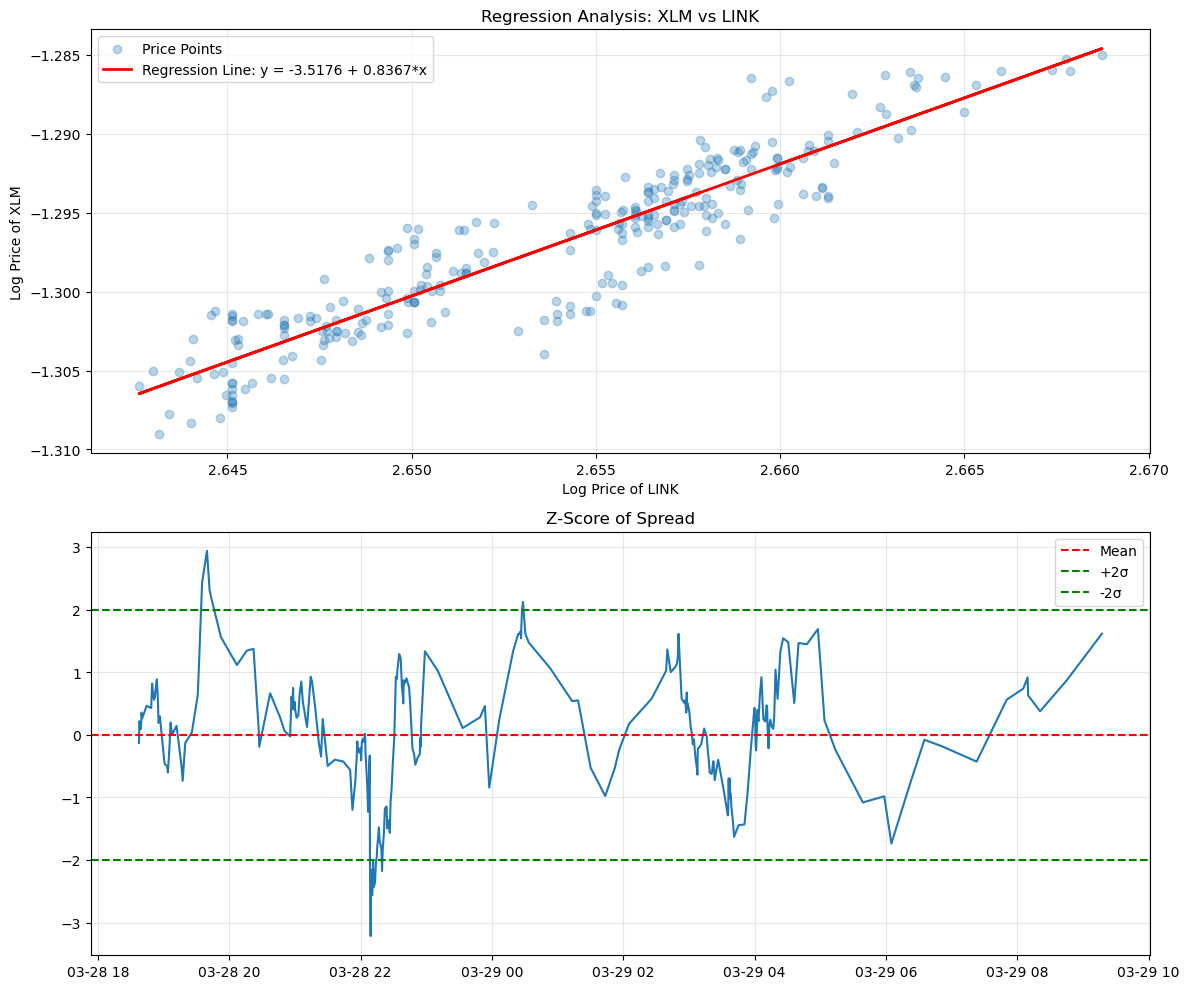

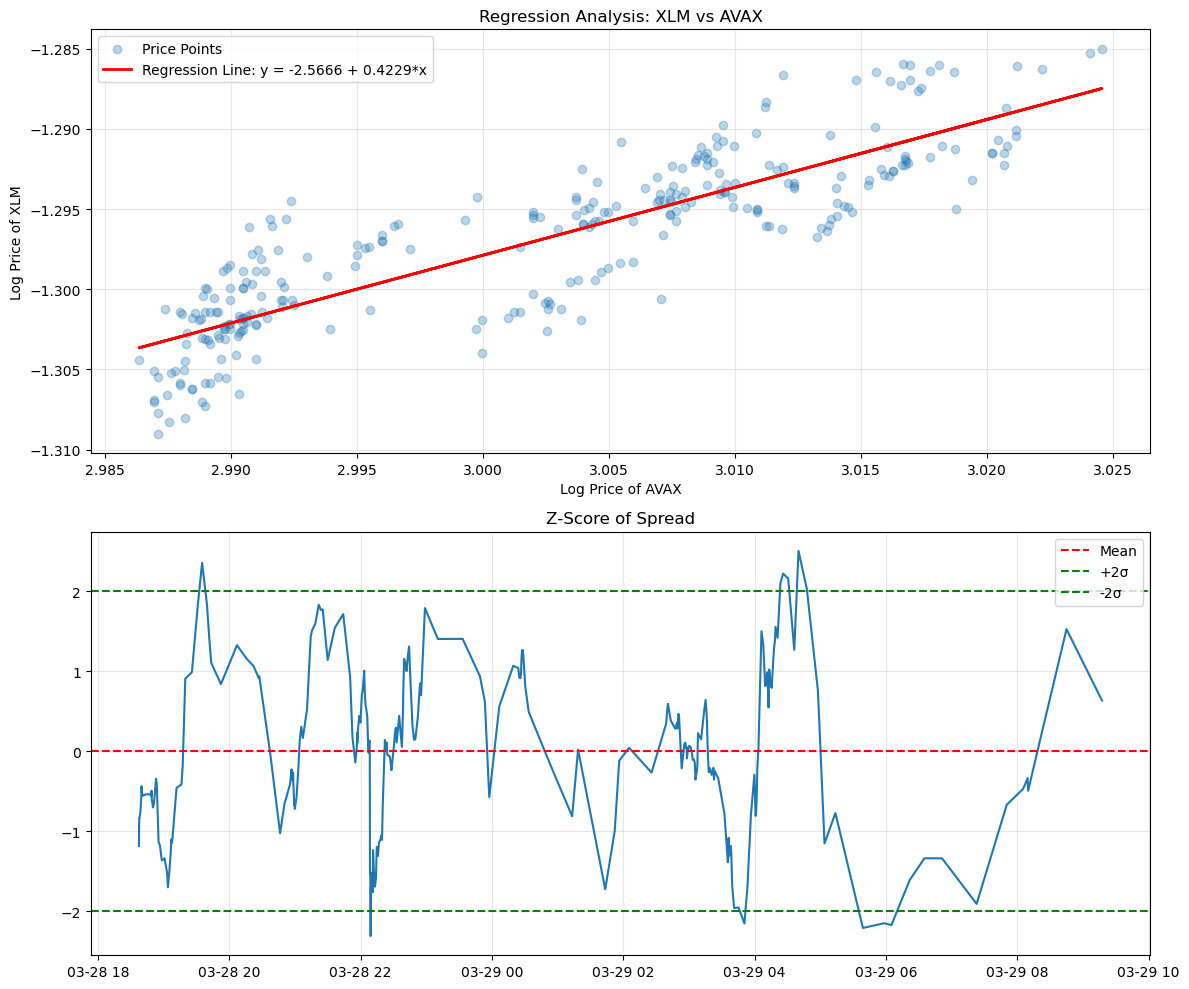

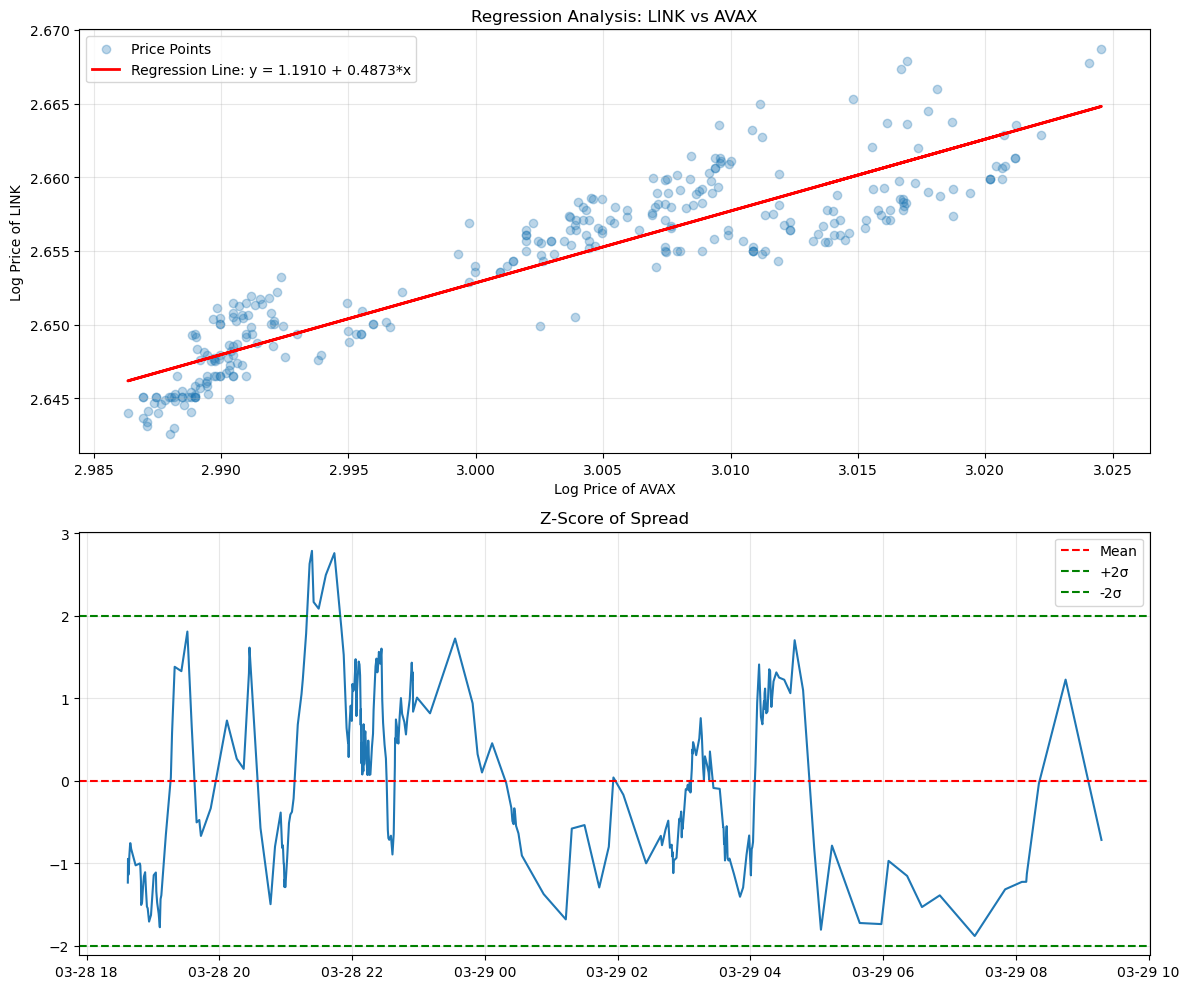

In [64]:
regression_results = perform_regression_analysis(cointegrated_pairs)

In [66]:
def backtest_stat_arb_strategy(regression_results, df, fee_bps=5, z_entry=2.0, z_exit=0.0, 
                              capital=10000, leverage=1.0, margin_call_threshold=0.2, plot_results=True):
    backtest_results = {}
    
    for pair_name, result in regression_results.items():
        symbol1, symbol2 = pair_name.split('-')
        
        pair_data = df[[symbol1, symbol2]].dropna()
        
        if len(pair_data) < 30:
            print(f"Skipping {pair_name}: Not enough data points after removing NaNs")
            continue
        
        price1 = pair_data[symbol1]
        price2 = pair_data[symbol2]
        
        log_price1 = np.log(price1)
        log_price2 = np.log(price2)
        
        alpha = result['Alpha']
        beta = result['Beta']
        
        spread = log_price1 - (alpha + beta * log_price2)
        z_score = (spread - spread.mean()) / spread.std()
        
        position = 0
        entry_z = 0
        entry_price1 = 0
        entry_price2 = 0
        trades = []
        margin_calls = 0
        
        equity_curve = [capital]
        current_capital = capital
        positions_history = [0]
        z_score_history = [z_score.iloc[0]]
        
        # Trading volume tracking
        daily_volumes = {}
        monthly_volumes = {}
        total_volume = 0
        
        for i in range(1, len(pair_data)):
            current_z = z_score.iloc[i]
            z_score_history.append(current_z)
            
            # Get current date for volume tracking
            current_date = pair_data.index[i]
            current_day = current_date.strftime('%Y-%m-%d')
            current_month = current_date.strftime('%Y-%m')
            
            if current_day not in daily_volumes:
                daily_volumes[current_day] = 0
            
            if current_month not in monthly_volumes:
                monthly_volumes[current_month] = 0
            
            # Calculate unrealized P&L if in a position
            unrealized_pnl = 0
            if position != 0:
                last_trade = next((t for t in reversed(trades) if t['type'] == 'entry'), None)
                if last_trade:
                    qty1 = abs(last_trade['qty1'])
                    qty2 = abs(last_trade['qty2'])
                    
                    if position == 1:  # Long spread
                        unrealized_pnl = qty1 * (price1.iloc[i] - entry_price1) + qty2 * (entry_price2 - price2.iloc[i])
                    else:  # Short spread
                        unrealized_pnl = qty1 * (entry_price1 - price1.iloc[i]) + qty2 * (price2.iloc[i] - entry_price2)
            
            # Check for margin call
            if position != 0:
                # Calculate current equity with unrealized P&L
                current_equity = current_capital + unrealized_pnl
                
                # Calculate initial margin required
                initial_margin = (last_trade['margin'] if 'margin' in last_trade else 0)
                
                # If equity falls below margin call threshold, force liquidation
                if current_equity < initial_margin * margin_call_threshold:
                    if position == 1:  # Long spread
                        pnl1 = qty1 * (price1.iloc[i] - entry_price1)
                        pnl2 = qty2 * (entry_price2 - price2.iloc[i])
                    else:  # Short spread
                        pnl1 = qty1 * (entry_price1 - price1.iloc[i])
                        pnl2 = qty2 * (price2.iloc[i] - entry_price2)
                    
                    total_pnl = pnl1 + pnl2
                    
                    # Calculate trade volume for margin call
                    trade_volume1 = qty1 * price1.iloc[i]
                    trade_volume2 = qty2 * price2.iloc[i]
                    trade_volume = trade_volume1 + trade_volume2
                    
                    # Update volume trackers
                    daily_volumes[current_day] += trade_volume
                    monthly_volumes[current_month] += trade_volume
                    total_volume += trade_volume
                    
                    fee1 = qty1 * price1.iloc[i] * (fee_bps / 10000)
                    fee2 = qty2 * price2.iloc[i] * (fee_bps / 10000)
                    current_capital += total_pnl - (fee1 + fee2)
                    
                    trades.append({
                        'type': 'margin_call',
                        'position': 'long_spread' if position == 1 else 'short_spread',
                        'date': pair_data.index[i],
                        'z_score': current_z,
                        'price1': price1.iloc[i],
                        'price2': price2.iloc[i],
                        'qty1': -last_trade['qty1'],
                        'qty2': -last_trade['qty2'],
                        'pnl': total_pnl,
                        'fees': fee1 + fee2,
                        'volume': trade_volume
                    })
                    
                    position = 0
                    margin_calls += 1
                    continue
            
            if position == 0:
                if current_z > z_entry:
                    position = -1
                    entry_z = current_z
                    entry_price1 = price1.iloc[i]
                    entry_price2 = price2.iloc[i]
                    
                    capital_per_leg = current_capital * leverage / 2
                    qty1 = capital_per_leg / price1.iloc[i]
                    qty2 = (capital_per_leg / price2.iloc[i]) * beta
                    
                    # Calculate trade volume
                    trade_volume1 = qty1 * price1.iloc[i]
                    trade_volume2 = qty2 * price2.iloc[i]
                    trade_volume = trade_volume1 + trade_volume2
                    
                    # Update volume trackers
                    daily_volumes[current_day] += trade_volume
                    monthly_volumes[current_month] += trade_volume
                    total_volume += trade_volume
                    
                    # Calculate required margin
                    required_margin = (qty1 * price1.iloc[i] + qty2 * price2.iloc[i]) / leverage
                    
                    fee1 = qty1 * price1.iloc[i] * (fee_bps / 10000)
                    fee2 = qty2 * price2.iloc[i] * (fee_bps / 10000)
                    current_capital -= (fee1 + fee2)
                    
                    trades.append({
                        'type': 'entry',
                        'position': 'short_spread',
                        'date': pair_data.index[i],
                        'z_score': current_z,
                        'price1': price1.iloc[i],
                        'price2': price2.iloc[i],
                        'qty1': -qty1,
                        'qty2': qty2,
                        'fees': fee1 + fee2,
                        'margin': required_margin,
                        'volume': trade_volume
                    })
                    
                elif current_z < -z_entry:
                    position = 1
                    entry_z = current_z
                    entry_price1 = price1.iloc[i]
                    entry_price2 = price2.iloc[i]
                    
                    capital_per_leg = current_capital * leverage / 2
                    qty1 = capital_per_leg / price1.iloc[i]
                    qty2 = (capital_per_leg / price2.iloc[i]) * beta
                    
                    # Calculate trade volume
                    trade_volume1 = qty1 * price1.iloc[i]
                    trade_volume2 = qty2 * price2.iloc[i]
                    trade_volume = trade_volume1 + trade_volume2
                    
                    # Update volume trackers
                    daily_volumes[current_day] += trade_volume
                    monthly_volumes[current_month] += trade_volume
                    total_volume += trade_volume
                    
                    # Calculate required margin
                    required_margin = (qty1 * price1.iloc[i] + qty2 * price2.iloc[i]) / leverage
                    
                    fee1 = qty1 * price1.iloc[i] * (fee_bps / 10000)
                    fee2 = qty2 * price2.iloc[i] * (fee_bps / 10000)
                    current_capital -= (fee1 + fee2)
                    
                    trades.append({
                        'type': 'entry',
                        'position': 'long_spread',
                        'date': pair_data.index[i],
                        'z_score': current_z,
                        'price1': price1.iloc[i],
                        'price2': price2.iloc[i],
                        'qty1': qty1,
                        'qty2': -qty2,
                        'fees': fee1 + fee2,
                        'margin': required_margin,
                        'volume': trade_volume
                    })
            
            elif position == 1:
                if current_z >= z_exit:
                    last_trade = next((t for t in reversed(trades) if t['position'] == 'long_spread' and t['type'] == 'entry'), None)
                    if last_trade:
                        qty1 = abs(last_trade['qty1'])
                        qty2 = abs(last_trade['qty2'])
                        
                        pnl1 = qty1 * (price1.iloc[i] - entry_price1)
                        pnl2 = qty2 * (entry_price2 - price2.iloc[i])
                        total_pnl = pnl1 + pnl2
                        
                        # Calculate trade volume
                        trade_volume1 = qty1 * price1.iloc[i]
                        trade_volume2 = qty2 * price2.iloc[i]
                        trade_volume = trade_volume1 + trade_volume2
                        
                        # Update volume trackers
                        daily_volumes[current_day] += trade_volume
                        monthly_volumes[current_month] += trade_volume
                        total_volume += trade_volume
                        
                        fee1 = qty1 * price1.iloc[i] * (fee_bps / 10000)
                        fee2 = qty2 * price2.iloc[i] * (fee_bps / 10000)
                        current_capital += total_pnl - (fee1 + fee2)
                        
                        trades.append({
                            'type': 'exit',
                            'position': 'long_spread',
                            'date': pair_data.index[i],
                            'z_score': current_z,
                            'price1': price1.iloc[i],
                            'price2': price2.iloc[i],
                            'qty1': -qty1,
                            'qty2': qty2,
                            'pnl': total_pnl,
                            'fees': fee1 + fee2,
                            'volume': trade_volume
                        })
                    
                    position = 0
            
            elif position == -1:
                if current_z <= z_exit:
                    last_trade = next((t for t in reversed(trades) if t['position'] == 'short_spread' and t['type'] == 'entry'), None)
                    if last_trade:
                        qty1 = abs(last_trade['qty1'])
                        qty2 = abs(last_trade['qty2'])
                        
                        pnl1 = qty1 * (entry_price1 - price1.iloc[i])
                        pnl2 = qty2 * (price2.iloc[i] - entry_price2)
                        total_pnl = pnl1 + pnl2
                        
                        # Calculate trade volume
                        trade_volume1 = qty1 * price1.iloc[i]
                        trade_volume2 = qty2 * price2.iloc[i]
                        trade_volume = trade_volume1 + trade_volume2
                        
                        # Update volume trackers
                        daily_volumes[current_day] += trade_volume
                        monthly_volumes[current_month] += trade_volume
                        total_volume += trade_volume
                        
                        fee1 = qty1 * price1.iloc[i] * (fee_bps / 10000)
                        fee2 = qty2 * price2.iloc[i] * (fee_bps / 10000)
                        current_capital += total_pnl - (fee1 + fee2)
                        
                        trades.append({
                            'type': 'exit',
                            'position': 'short_spread',
                            'date': pair_data.index[i],
                            'z_score': current_z,
                            'price1': price1.iloc[i],
                            'price2': price2.iloc[i],
                            'qty1': qty1,
                            'qty2': -qty2,
                            'pnl': total_pnl,
                            'fees': fee1 + fee2,
                            'volume': trade_volume
                        })
                    
                    position = 0
            
            equity_curve.append(current_capital)
            positions_history.append(position)
        
        equity_series = pd.Series(equity_curve, index=pair_data.index)
        returns = equity_series.pct_change().dropna()
        
        # Calculate 30-day trailing volume at the end of the backtest
        last_date = pair_data.index[-1]
        thirty_days_ago = last_date - pd.Timedelta(days=30)
        trailing_30d_volume = sum(vol for date, vol in daily_volumes.items() 
                                if pd.Timestamp(date) >= thirty_days_ago)
        
        
        # Calculate average daily and monthly volumes
        avg_daily_volume = sum(daily_volumes.values()) / len(daily_volumes) if daily_volumes else 0
        avg_monthly_volume = sum(monthly_volumes.values()) / len(monthly_volumes) if monthly_volumes else 0
        
        total_trades = len([t for t in trades if t['type'] == 'exit' or t['type'] == 'margin_call'])
        winning_trades = len([t for t in trades if (t['type'] == 'exit' or t['type'] == 'margin_call') and t['pnl'] > 0])
        losing_trades = len([t for t in trades if (t['type'] == 'exit' or t['type'] == 'margin_call') and t['pnl'] < 0])
        
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
            
        total_profit = sum([t['pnl'] for t in trades if t['type'] == 'exit' or t['type'] == 'margin_call'])
        total_fees = sum([t['fees'] for t in trades])
        net_profit = total_profit - total_fees
        
        winning_trades_sum = sum([t['pnl'] for t in trades if (t['type'] == 'exit' or t['type'] == 'margin_call') and t['pnl'] > 0])
        losing_trades_sum = sum([abs(t['pnl']) for t in trades if (t['type'] == 'exit' or t['type'] == 'margin_call') and t['pnl'] < 0])
        profit_factor = winning_trades_sum / losing_trades_sum if losing_trades_sum > 0 else float('inf')
        
        backtest_results[pair_name] = {
            'Equity Curve': equity_series,
            'Returns': returns,
            'Trades': trades,
            'Positions': positions_history,
            'Z-Scores': z_score_history,
            'Total Trades': total_trades,
            'Win Rate': win_rate,
            'Total Profit': total_profit,
            'Total Fees': total_fees,
            'Net Profit': net_profit,
            'Final Equity': current_capital,
            'Return': (current_capital / capital - 1) * 100,
            'Sharpe Ratio': returns.mean() / returns.std() * np.sqrt(252) if len(returns) > 0 and returns.std() > 0 else 0,
            'Max Drawdown': (equity_series / equity_series.cummax() - 1).min() * 100,
            'Profit Factor': profit_factor,
            'Margin Calls': margin_calls,
            'Total Volume': total_volume,
            'Average Daily Volume': avg_daily_volume,
            'Average Monthly Volume': avg_monthly_volume,
            'Trailing 30d Volume': trailing_30d_volume,
            'Daily Volumes': daily_volumes,
            'Monthly Volumes': monthly_volumes
        }
        
        if plot_results:
            fig, axes = plt.subplots(3, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [2, 1, 1]})
            
            ax0 = axes[0]
            ax0.set_title(f'Price Movement: {symbol1} vs {symbol2}')
            ax0.plot(pair_data.index, price1 / price1.iloc[0], label=f'{symbol1} (normalized)')
            ax0.plot(pair_data.index, price2 / price2.iloc[0], label=f'{symbol2} (normalized)')
            ax0.legend()
            ax0.grid(True, alpha=0.3)
            
            ax1 = axes[1]
            ax1.set_title('Z-Score with Trading Signals')
            ax1.plot(pair_data.index, z_score)
            ax1.axhline(y=0, color='r', linestyle='--')
            ax1.axhline(y=z_entry, color='g', linestyle='--', label=f'Entry (+{z_entry})')
            ax1.axhline(y=-z_entry, color='g', linestyle='--', label=f'Entry (-{z_entry})')
            ax1.axhline(y=z_exit, color='b', linestyle=':', label=f'Exit ({z_exit})')
            ax1.axhline(y=-z_exit, color='b', linestyle=':', label=f'Exit (-{z_exit})')
            
            for trade in trades:
                if trade['type'] == 'entry':
                    if trade['position'] == 'long_spread':
                        ax1.scatter(trade['date'], trade['z_score'], marker='^', color='g', s=100)
                    else:
                        ax1.scatter(trade['date'], trade['z_score'], marker='v', color='r', s=100)
                elif trade['type'] == 'exit':
                    ax1.scatter(trade['date'], trade['z_score'], marker='o', color='b', s=100)
                elif trade['type'] == 'margin_call':
                    ax1.scatter(trade['date'], trade['z_score'], marker='x', color='k', s=100)
            
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            ax2 = axes[2]
            ax2.set_title('Equity Curve')
            ax2.plot(pair_data.index, equity_curve)
            ax2.grid(True, alpha=0.3)
            
            metrics_text = (
                f"Total Trades: {total_trades}\n"
                f"Win Rate: {win_rate:.2%}\n"
                f"Net Profit: ${net_profit:.2f}\n"
                f"Return: {backtest_results[pair_name]['Return']:.2f}%\n"
                f"Sharpe Ratio: {backtest_results[pair_name]['Sharpe Ratio']:.2f}\n"
                f"Max Drawdown: {backtest_results[pair_name]['Max Drawdown']:.2f}%\n"
                f"Profit Factor: {profit_factor:.2f}\n"
                f"Total Fees: ${total_fees:.2f}\n"
                f"Margin Calls: {margin_calls}\n"
                f"Total Volume: ${total_volume:.2f}\n"
                f"Avg Daily Volume: ${avg_daily_volume:.2f}\n"
                f"Trailing 30d Volume: ${trailing_30d_volume:.2f}\n"
            )
            
            ax2.annotate(metrics_text, xy=(0.02, 0.05), xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
            
            plt.tight_layout()
            plt.savefig(f'trade_{symbol1}{symbol2}.png')
            plt.show()
            
            if total_trades > 0:
                pnls = [t['pnl'] for t in trades if t['type'] == 'exit' or t['type'] == 'margin_call']
                plt.figure(figsize=(10, 6))
                plt.hist(pnls, bins=20)
                plt.axvline(x=0, color='r', linestyle='--')
                plt.title(f'Trade P&L Distribution - {pair_name}')
                plt.xlabel('P&L ($)')
                plt.ylabel('Frequency')
                plt.grid(True, alpha=0.3)
                plt.savefig(f'PnL_dis_{symbol1}{symbol2}.png')
                plt.show()
    
    return backtest_results


In [67]:
def analyze_backtest_results(backtest_results):
    """
    Analyze and compare backtest results across different pairs
    
    Parameters:
    -----------
    backtest_results : dict
        Dictionary containing backtest results from backtest_stat_arb_strategy
    """
    if not backtest_results:
        print("No backtest results to analyze.")
        return None
        
    summary = {}
    
    for pair_name, result in backtest_results.items():
        summary[pair_name] = {
            'Total Trades': result['Total Trades'],
            'Win Rate': result['Win Rate'],
            'Net Profit': result['Net Profit'],
            'Return (%)': result['Return'],
            'Sharpe Ratio': result['Sharpe Ratio'],
            'Max Drawdown (%)': result['Max Drawdown'],
            'Profit Factor': result['Profit Factor']
        }
    
    summary_df = pd.DataFrame.from_dict(summary, orient='index')
    
    # Plot comparison
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    summary_df['Return (%)'].plot(kind='bar')
    plt.title('Return (%)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 2)
    summary_df['Sharpe Ratio'].plot(kind='bar')
    plt.title('Sharpe Ratio')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 3)
    summary_df['Win Rate'].plot(kind='bar')
    plt.title('Win Rate')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 4)
    summary_df['Profit Factor'].plot(kind='bar')
    plt.title('Profit Factor')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('PnL.png')
    plt.show()
    
    # Display summary table
    print("Performance Summary:")
    print(summary_df)
    
    return summary_df

### fee
https://docs.dydx.exchange/introduction-trading_fees

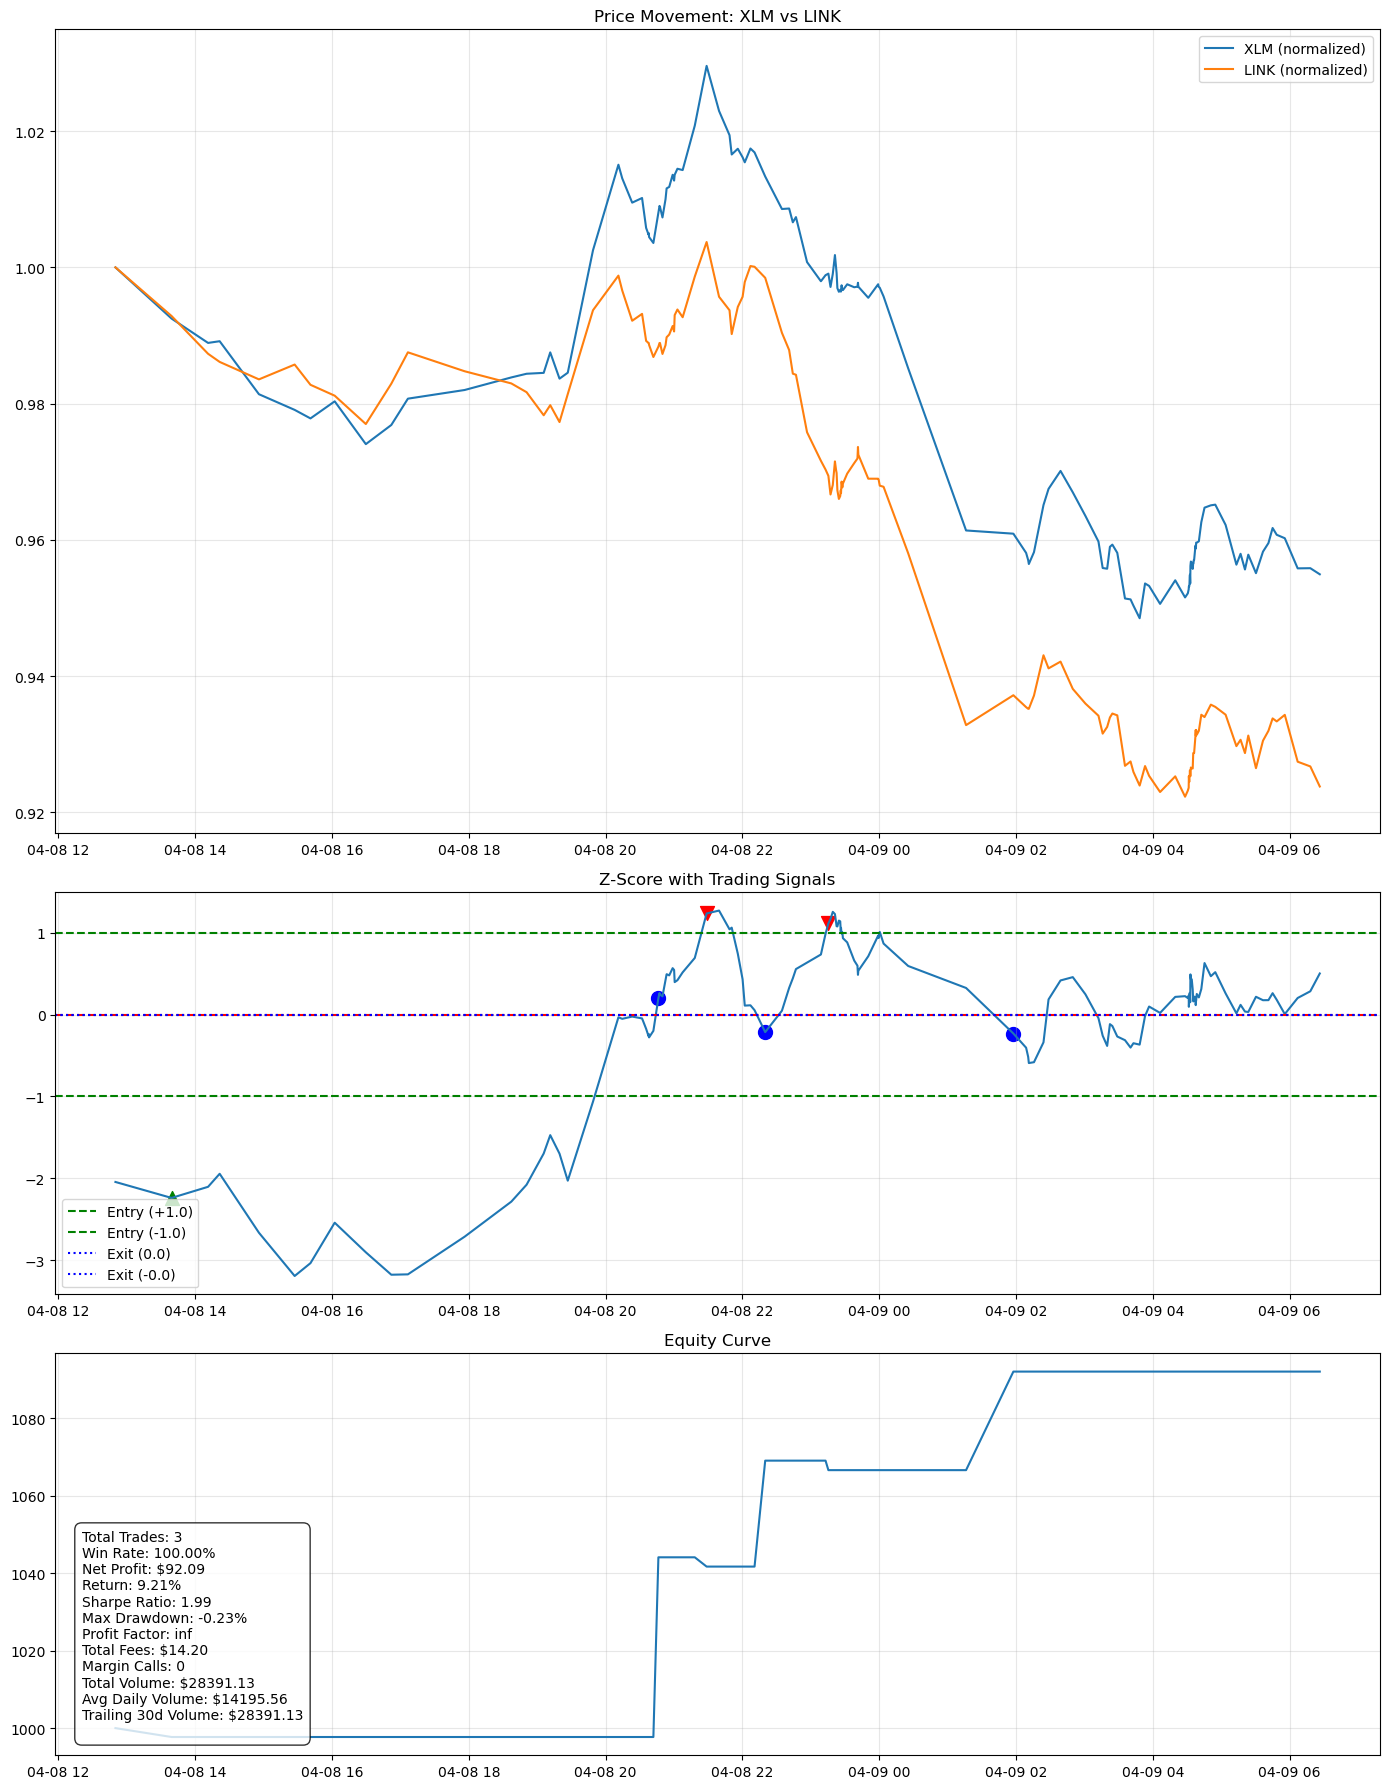

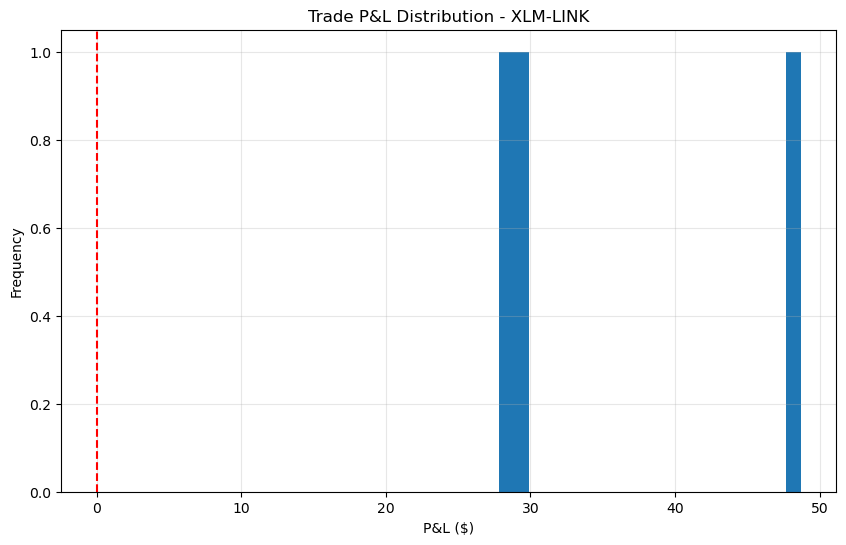

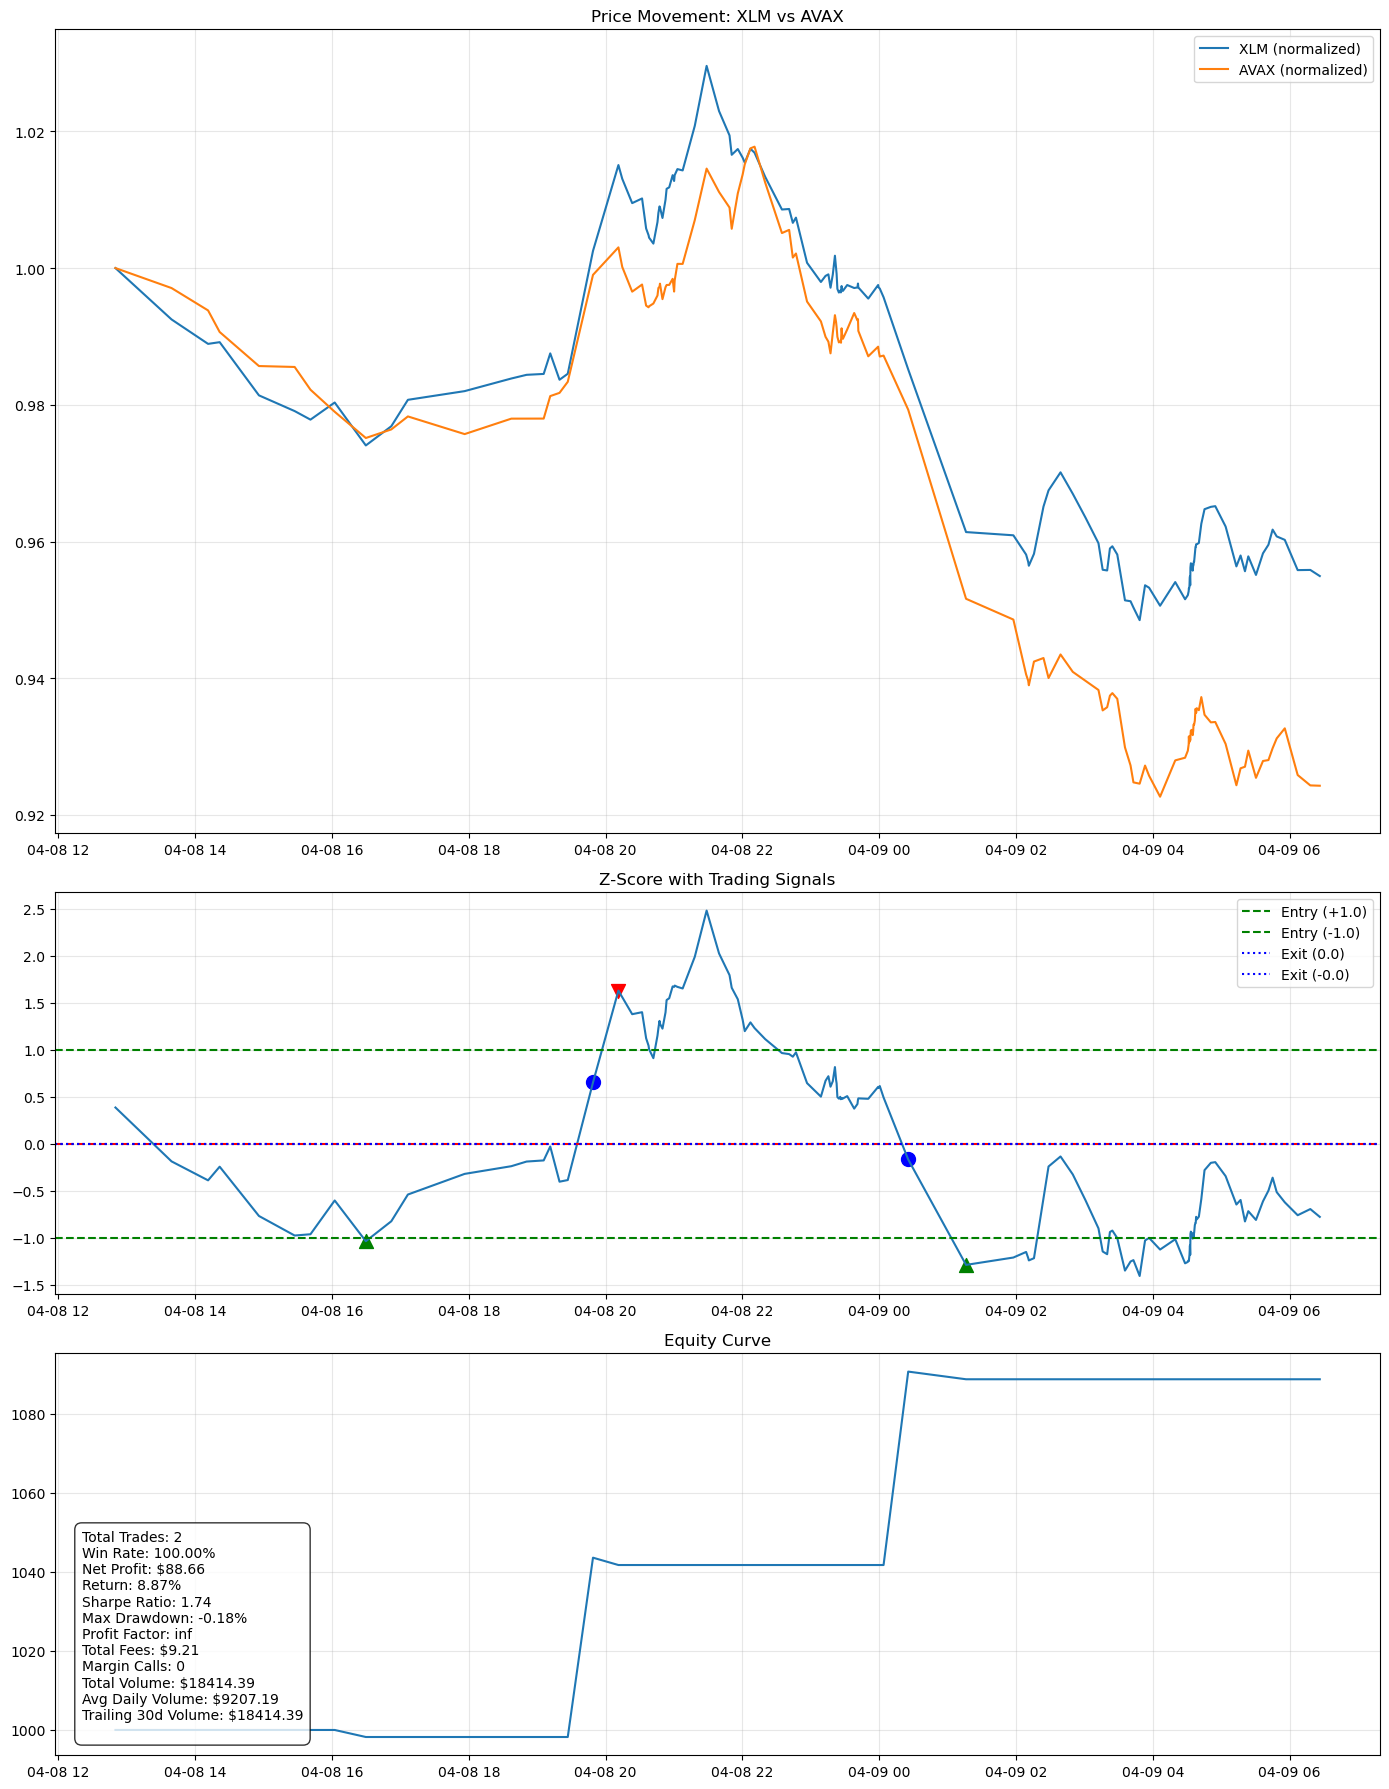

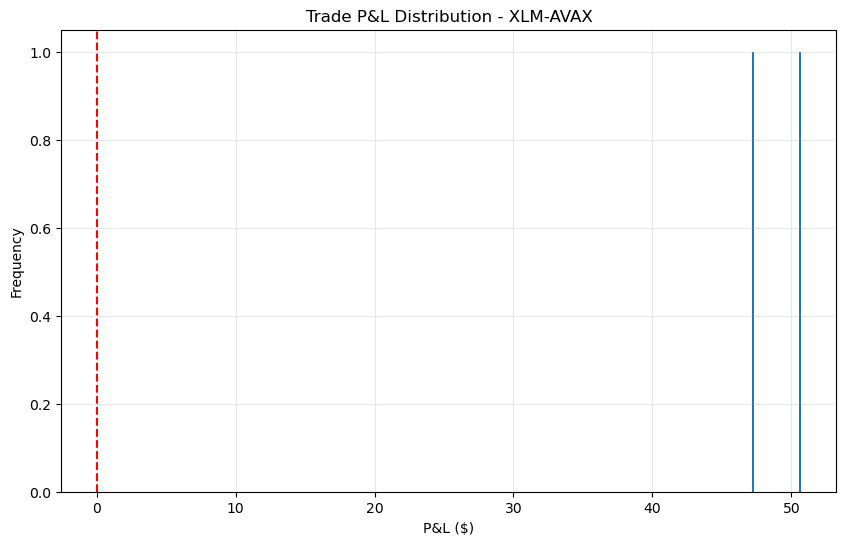

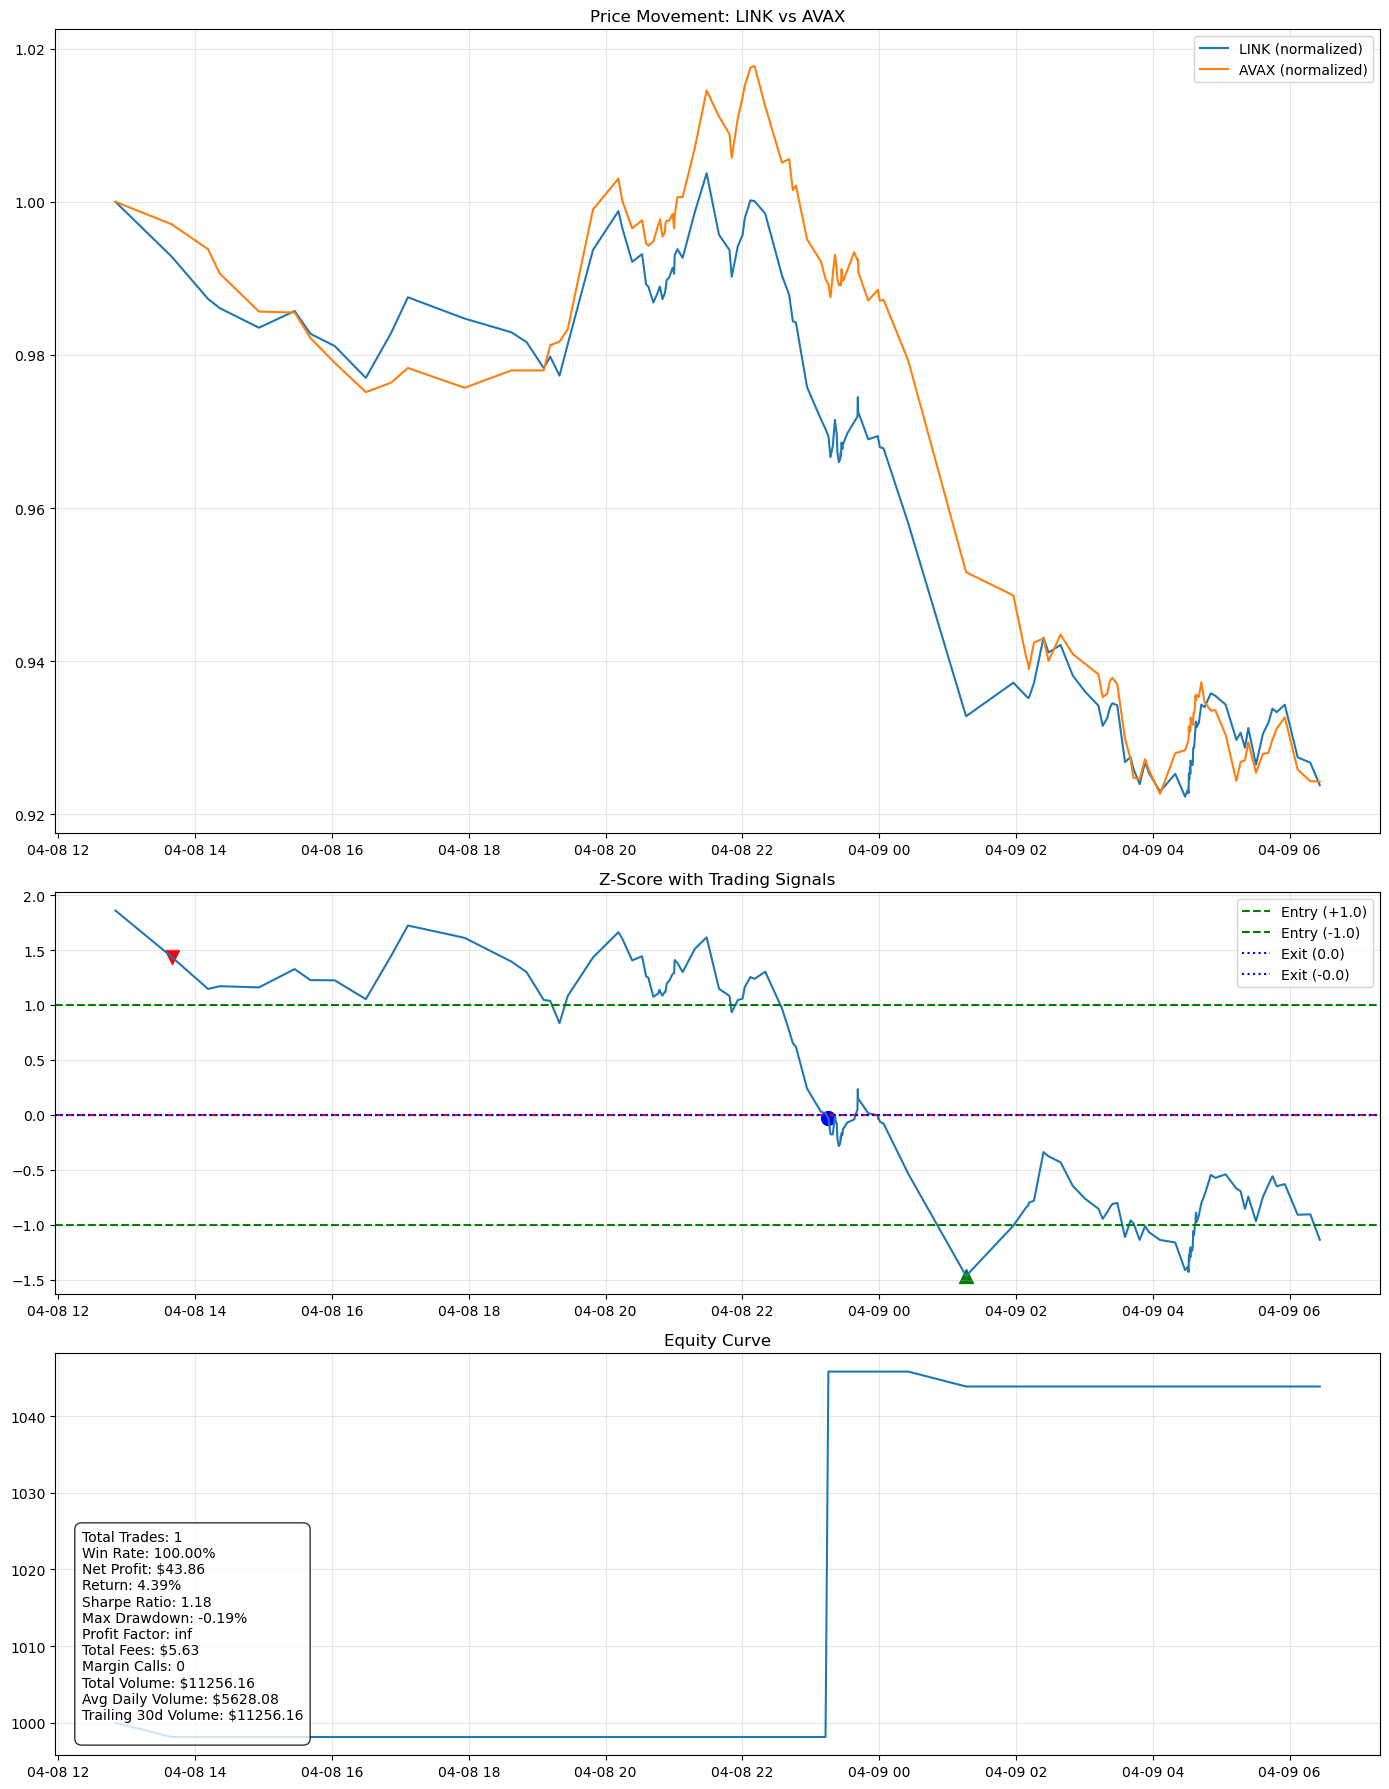

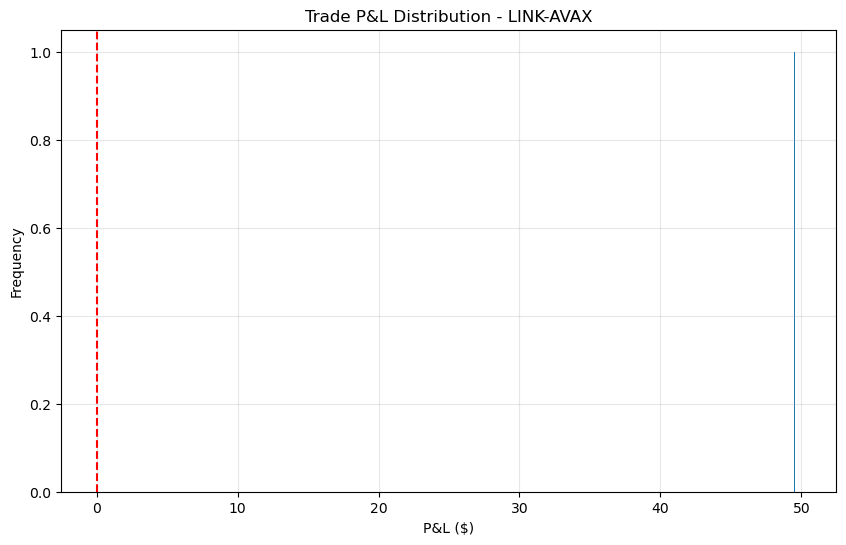

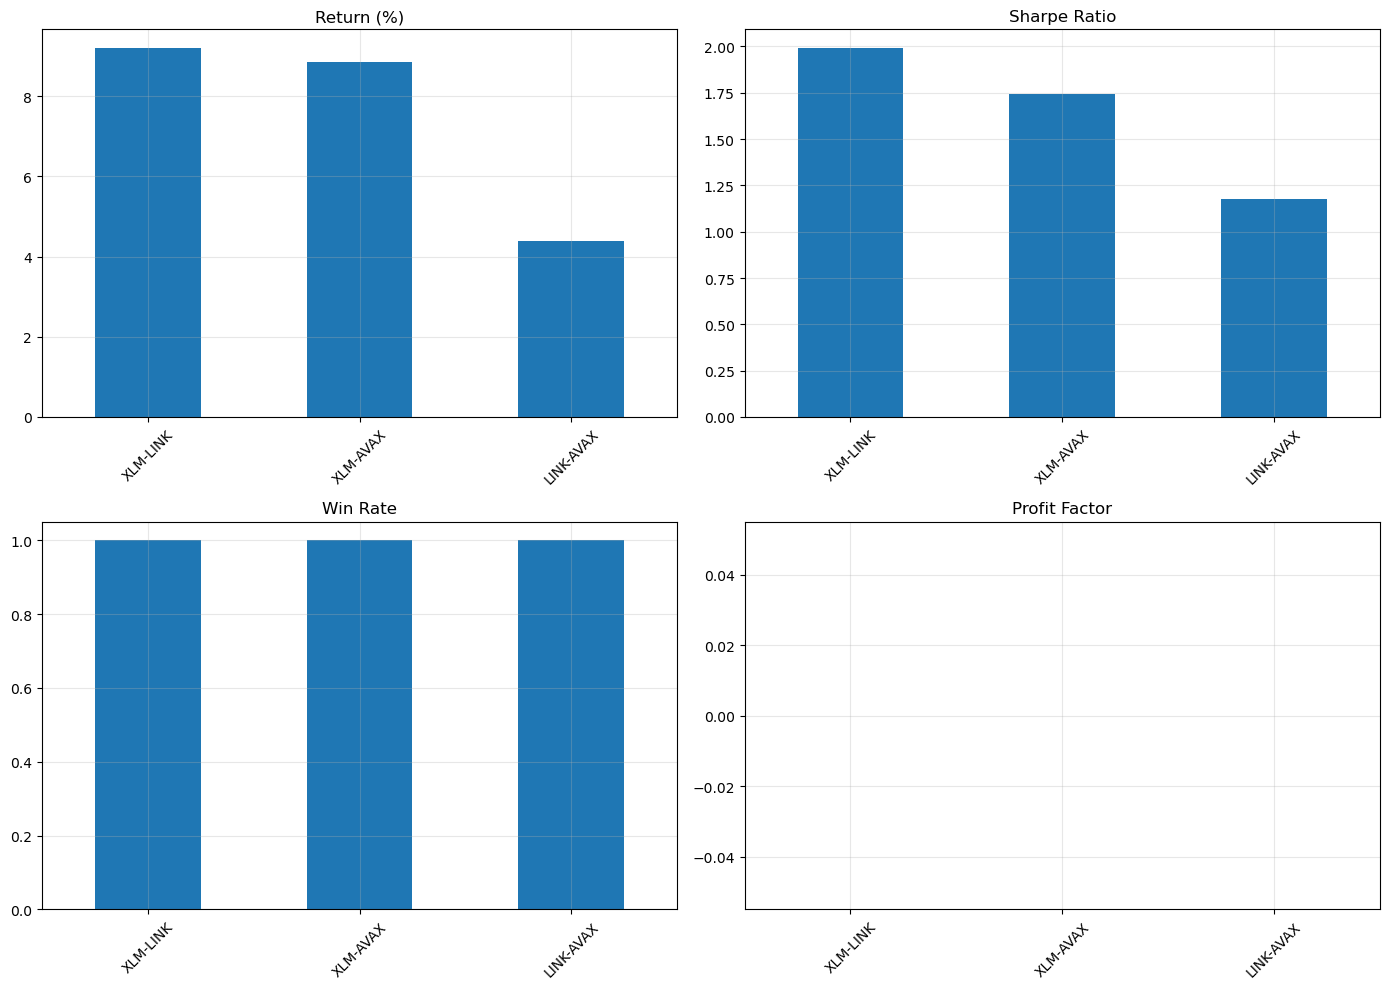

Performance Summary:
           Total Trades  Win Rate  Net Profit  Return (%)  Sharpe Ratio  \
XLM-LINK              3       1.0   92.087547    9.208755      1.992879   
XLM-AVAX              2       1.0   88.660369    8.866037      1.741165   
LINK-AVAX             1       1.0   43.862020    4.386202      1.177235   

           Max Drawdown (%)  Profit Factor  
XLM-LINK          -0.229589            inf  
XLM-AVAX          -0.177863            inf  
LINK-AVAX         -0.185908            inf  


In [69]:
df_test = dfs[1]
backtest_results = backtest_stat_arb_strategy(regression_results, df_test, fee_bps=5, z_entry=1.0, z_exit=0.0, 
                              capital=1000, leverage=5.0, margin_call_threshold=0.2)
summary = analyze_backtest_results(backtest_results)